# TensorFlow 深度學習模型訓練實驗

本 Notebook 用於訓練和評估用於詐欺偵測的 TensorFlow/Keras 深度神經網路模型。

## 目標
- 使用深度學習技術處理高度不平衡的詐欺偵測數據
- 比較深度學習與傳統機器學習方法（Logistic Regression, XGBoost）的性能
- 調整超參數以優化 F1 Score 和 Recall

## 模型架構
- Input Layer (30 features)
- Dense Layers with BatchNormalization and Dropout
- Output Layer (Binary Classification)

作者: Fraud Detection Team  
日期: 2025-11-20


In [13]:
# 1. 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

# 顯示設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 檢查 TensorFlow 和 GPU 狀態
print(f"TensorFlow 版本: {tf.__version__}")
print(f"GPU 可用: {tf.config.list_physical_devices('GPU')}")
print(f"Keras 版本: {keras.__version__}")


TensorFlow 版本: 2.20.0
GPU 可用: []
Keras 版本: 3.12.0


## 2. 資料載入與預處理

複用與其他模型相同的資料處理流程，確保公平比較。


In [14]:
# 載入資料
df = pd.read_csv('../data/creditcard.csv')

print(f"資料集大小: {df.shape}")
print(f"\n類別分佈:")
print(df['Class'].value_counts())
print(f"\n詐欺比例: {df['Class'].sum() / len(df) * 100:.2f}%")

# 特徵工程：標準化 Time 和 Amount
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 儲存 scaler 供 API 使用（與其他模型共用）
import joblib
import os
model_dir = '../src/models'
os.makedirs(model_dir, exist_ok=True)
scaler_path = os.path.join(model_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"\nScaler 已儲存至: {scaler_path}")

# 移除原始 Time 和 Amount
df_processed = df.drop(['Time', 'Amount'], axis=1)

# 定義特徵和目標
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

print(f"\n特徵數量: {X.shape[1]}")
print(f"特徵列表: {list(X.columns)}")


資料集大小: (284807, 31)

類別分佈:
Class
0    284315
1       492
Name: count, dtype: int64

詐欺比例: 0.17%

Scaler 已儲存至: ../src/models\scaler.pkl

特徵數量: 30
特徵列表: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaled_amount', 'scaled_time']


In [15]:
# 分割訓練集與測試集（與其他模型保持一致）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"\n訓練集詐欺比例: {y_train.sum() / len(y_train) * 100:.2f}%")
print(f"測試集詐欺比例: {y_test.sum() / len(y_test) * 100:.2f}%")


訓練集大小: (227845, 30)
測試集大小: (56962, 30)

訓練集詐欺比例: 0.17%
測試集詐欺比例: 0.17%


## 3. 處理類別不平衡

計算類別權重，讓模型更關注少數類別（詐欺交易）。


In [16]:
# 計算類別權重
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight = {int(classes[i]): weights[i] for i in range(len(classes))}

print(f"類別權重: {class_weight}")
print(f"正常交易權重: {class_weight[0]:.4f}")
print(f"詐欺交易權重: {class_weight[1]:.4f}")
print(f"權重比例: {class_weight[1] / class_weight[0]:.2f}x")


類別權重: {0: np.float64(0.5008661206149896), 1: np.float64(289.14340101522845)}
正常交易權重: 0.5009
詐欺交易權重: 289.1434
權重比例: 577.29x


## 4. 建構 TensorFlow/Keras 模型


In [17]:
def build_fraud_detection_model(input_dim, learning_rate=0.001):
    """
    構建深度神經網路用於詐欺偵測
    """
    model = keras.Sequential([
        # 輸入層
        layers.Input(shape=(input_dim,), name='input_features'),
        
        # 第一層：較大的隱藏層捕捉複雜模式
        layers.Dense(128, activation='relu', name='dense_1'),
        layers.BatchNormalization(name='bn_1'),
        layers.Dropout(0.3, name='dropout_1'),
        
        # 第二層：中等大小的隱藏層
        layers.Dense(64, activation='relu', name='dense_2'),
        layers.BatchNormalization(name='bn_2'),
        layers.Dropout(0.2, name='dropout_2'),
        
        # 第三層：較小的隱藏層
        layers.Dense(32, activation='relu', name='dense_3'),
        layers.Dropout(0.1, name='dropout_3'),
        
        # 輸出層：二元分類
        layers.Dense(1, activation='sigmoid', name='output')
    ], name='FraudDetectionModel')
    
    # 編譯模型
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# 建立模型
input_dim = X_train.shape[1]
model = build_fraud_detection_model(input_dim=input_dim, learning_rate=0.001)

# 顯示模型架構
model.summary()


Model: "FraudDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 384 (1.50 KB)

## 5. 設定訓練 Callbacks

使用 Early Stopping 和 Learning Rate Reduction 優化訓練過程。


In [18]:
# 定義 Callbacks
callback_list = [
    # Early Stopping: 當 val_auc 不再提升時停止訓練
    callbacks.EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    # Learning Rate Reduction: 當 loss 停滯時降低學習率
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks 設定完成：")
print("- Early Stopping (monitor=val_auc, patience=10)")
print("- ReduceLROnPlateau (monitor=val_loss, patience=5)")


Callbacks 設定完成：
- Early Stopping (monitor=val_auc, patience=10)
- ReduceLROnPlateau (monitor=val_loss, patience=5)


## 6. 訓練模型


In [19]:
# 訓練模型
history = model.fit(
    X_train.values,
    y_train.values,
    validation_data=(X_test.values, y_test.values),
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callback_list,
    verbose=1
)

print("\n訓練完成！")


Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9199 - auc: 0.9490 - loss: 0.2587 - precision: 0.0187 - recall: 0.8807 - val_accuracy: 0.9599 - val_auc: 0.9704 - val_loss: 0.1452 - val_precision: 0.0385 - val_recall: 0.9286 - learning_rate: 0.0010
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9575 - auc: 0.9805 - loss: 0.1586 - precision: 0.0363 - recall: 0.9239 - val_accuracy: 0.9579 - val_auc: 0.9647 - val_loss: 0.1200 - val_precision: 0.0367 - val_recall: 0.9286 - learning_rate: 0.0010
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9612 - auc: 0.9895 - loss: 0.1273 - precision: 0.0402 - recall: 0.9365 - val_accuracy: 0.9709 - val_auc: 0.9709 - val_loss: 0.0885 - val_precision: 0.0507 - val_recall: 0.8980 - learning_rate: 0.0010
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9589 - auc: 0.9885 - loss: 0.1352 - precision: 0.0376 - recall: 0.9264 - val_accuracy: 0.9572 - val_auc: 0.9749 - val_loss: 0.1102 - val

## 7. 訓練歷史視覺化


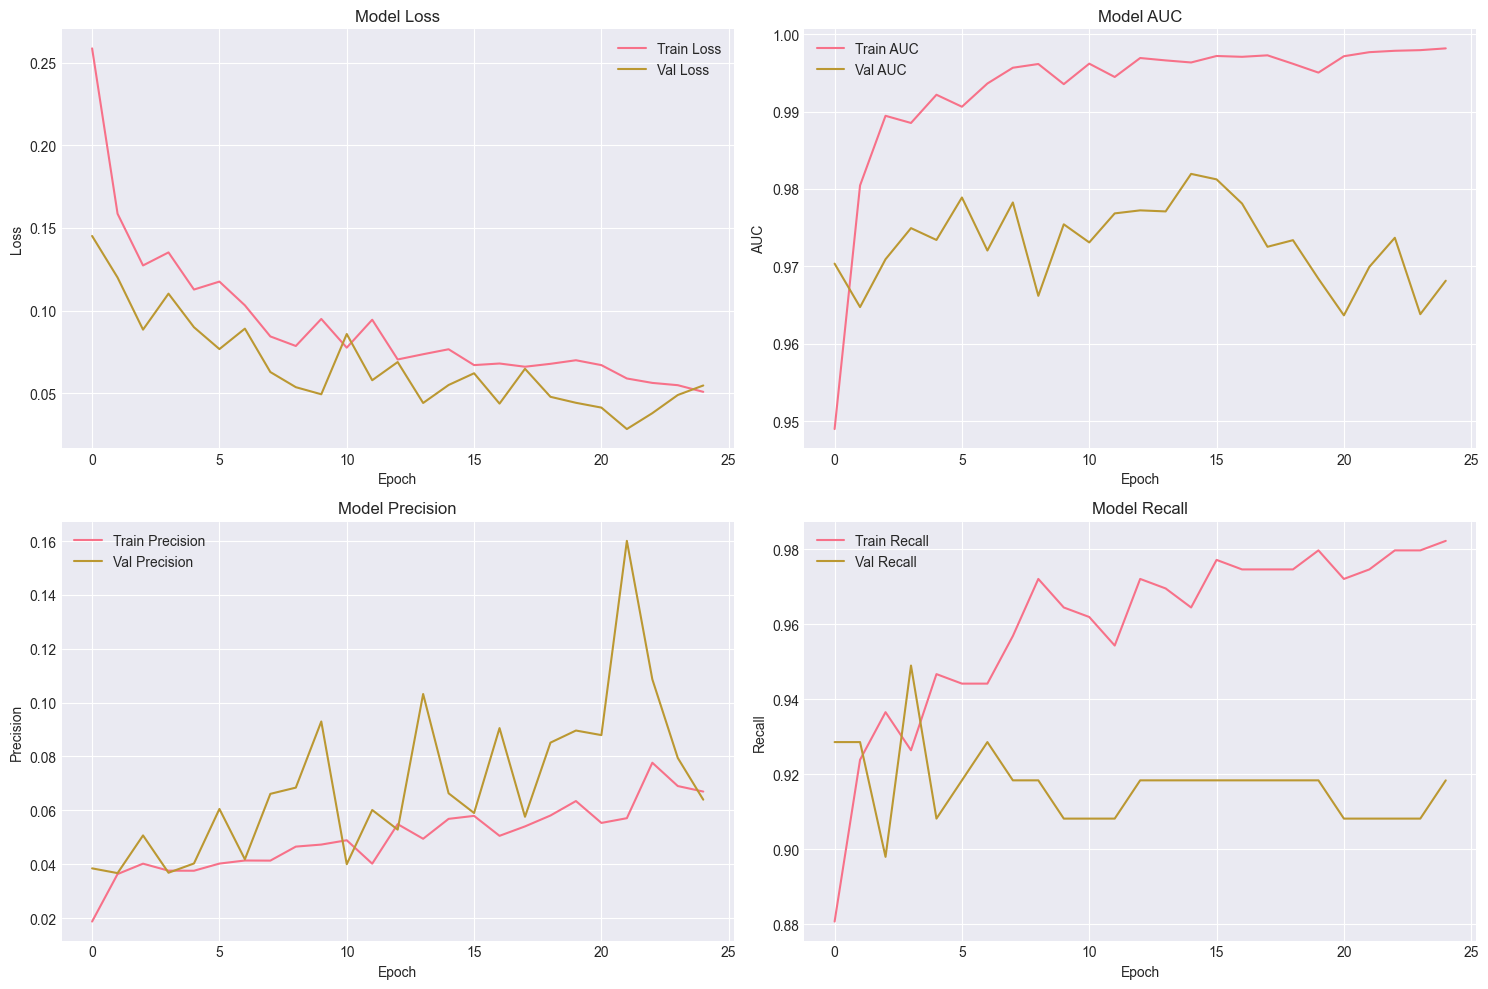

In [20]:
# 繪製訓練歷史
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train AUC')
axes[0, 1].plot(history.history['val_auc'], label='Val AUC')
axes[0, 1].set_title('Model AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


## 8. 模型評估


In [21]:
# 預測
y_proba = model.predict(X_test.values).flatten()
y_pred = (y_proba > 0.5).astype(int)

# 計算評估指標
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("=" * 50)
print("TensorFlow 模型評估結果")
print("=" * 50)
print(f"AUC Score:        {auc:.4f}")
print(f"F1 Score:         {f1:.4f}")
print(f"Precision Score:  {precision:.4f}")
print(f"Recall Score:     {recall:.4f}")
print("=" * 50)

# 混淆矩陣
print("\n混淆矩陣:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# 分類報告
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=['正常', '詐欺']))


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step
TensorFlow 模型評估結果
AUC Score:        0.9829
F1 Score:         0.1237
Precision Score:  0.0663
Recall Score:     0.9184

混淆矩陣:
[[55597  1267]
 [    8    90]]

分類報告:
              precision    recall  f1-score   support

          正常       1.00      0.98      0.99     56864
          詐欺       0.07      0.92      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962



## 9. ROC 曲線與 Precision-Recall 曲線


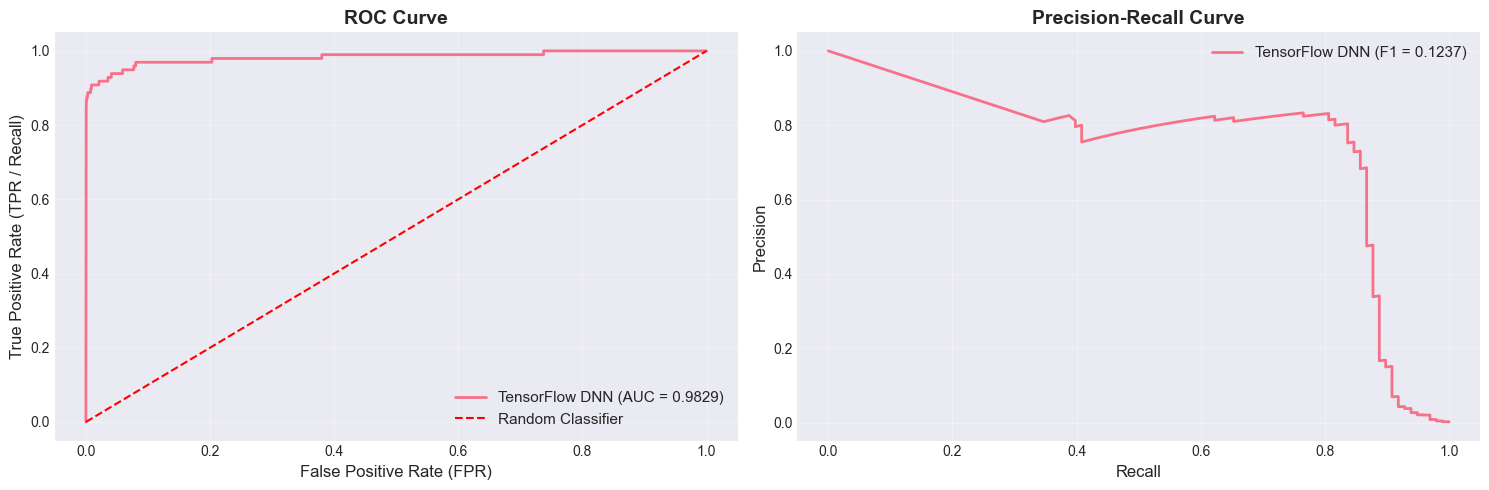

In [22]:
# 繪製 ROC 曲線和 Precision-Recall 曲線
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
axes[0].plot(fpr, tpr, label=f'TensorFlow DNN (AUC = {auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'r--', label='Random Classifier')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].set_xlabel('False Positive Rate (FPR)', fontsize=12)
axes[0].set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall 曲線
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
axes[1].plot(recall_curve, precision_curve, label=f'TensorFlow DNN (F1 = {f1:.4f})', linewidth=2)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. 儲存模型（供 API 使用）

**注意：Keras 3.0+ API 變化**
- ✅ 推薦格式：`.keras` (原生 Keras 格式)
- ⚠️  舊格式：`.h5` (HDF5 格式，已棄用)
- 🔧 SavedModel：使用 `model.export()` 而非 `model.save()`


In [23]:
# 儲存 TensorFlow 模型
# Keras 3.0+ 推薦使用 .keras 格式
model_path = os.path.join(model_dir, 'tensorflow_fraud_model.keras')
model.save(model_path)
print(f"✅ TensorFlow 模型已儲存至: {model_path}")

# SavedModel 格式（用於生產部署和 MLflow）
# Keras 3.0+ 使用 export() 而不是 save()
saved_model_dir = os.path.join(model_dir, 'tensorflow_fraud_model')
try:
    if hasattr(model, 'export'):
        # Keras 3.0+ API
        model.export(saved_model_dir)
        print(f"✅ SavedModel 格式已儲存至: {saved_model_dir}")
    else:
        # 舊版 API 備用
        tf.saved_model.save(model, saved_model_dir)
        print(f"✅ SavedModel 格式已儲存至: {saved_model_dir} (使用 tf.saved_model)")
except Exception as e:
    print(f"⚠️  SavedModel 儲存失敗: {e}")
    print("不影響使用，.keras 格式已成功儲存")

print("\n✅ 模型儲存完成，可供 API 和 ETL pipeline 使用")


✅ TensorFlow 模型已儲存至: ../src/models\tensorflow_fraud_model.keras
INFO:tensorflow:Assets written to: ../src/models\tensorflow_fraud_model\assets


INFO:tensorflow:Assets written to: ../src/models\tensorflow_fraud_model\assets


Saved artifact at '../src/models\tensorflow_fraud_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='input_features')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2231886794000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886793808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886792848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886791888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886792656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886793232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886791312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886791696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886793616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886795152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2231886794768: Tensor

## 11. 與其他模型的性能比較

根據之前的實驗結果，與 Logistic Regression、XGBoost 等模型進行比較。

**預期結果：**
- Logistic Regression: F1 ~0.11, AUC ~0.97
- XGBoost: F1 較高，但訓練時間較長
- TensorFlow DNN: F1 可能介於兩者之間，但具有更好的彈性

**優勢：**
- 可以處理非線性複雜關係
- 可以透過調整架構和超參數進一步優化
- 支援更複雜的特徵工程和嵌入層
